## Fine Tuning BERT-Based-Uncased Hugging Face Model on Kaggle Hate Speech Dataset

# [Link to my Youtube Video Explaining this whole Notebook](https://www.youtube.com/watch?v=0Y03waAL4Gw&list=PLxqBkZuBynVTn2lkHNAcw6lgm1MD5QiMK&index=3)

[![Imgur](https://imgur.com/dJt4A8B.png)](https://www.youtube.com/watch?v=0Y03waAL4Gw&list=PLxqBkZuBynVTn2lkHNAcw6lgm1MD5QiMK&index=3)
---

### [Dataset in Kaggle](https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset?ref=hackernoon.com)

## First What is BERT?

BERT stands for Bidirectional Encoder Representations from Transformers. The name itself gives us several clues to what BERT is all about.

BERT architecture consists of several Transformer encoders stacked together. Each Transformer encoder encapsulates two sub-layers: a self-attention layer and a feed-forward layer.

### There are two different BERT models:

- BERT base, which is a BERT model consists of 12 layers of Transformer encoder, 12 attention heads, 768 hidden size, and 110M parameters.

- BERT large, which is a BERT model consists of 24 layers of Transformer encoder,16 attention heads, 1024 hidden size, and 340 parameters.



BERT Input and Output
BERT model expects a sequence of tokens (words) as an input. In each sequence of tokens, there are two special tokens that BERT would expect as an input:

- [CLS]: This is the first token of every sequence, which stands for classification token.
- [SEP]: This is the token that makes BERT know which token belongs to which sequence. This special token is mainly important for a next sentence prediction task or question-answering task. If we only have one sequence, then this token will be appended to the end of the sequence.


It is also important to note that the maximum size of tokens that can be fed into BERT model is 512. If the tokens in a sequence are less than 512, we can use padding to fill the unused token slots with [PAD] token. If the tokens in a sequence are longer than 512, then we need to do a truncation.

And that’s all that BERT expects as input.

BERT model then will output an embedding vector of size 768 in each of the tokens. We can use these vectors as an input for different kinds of NLP applications, whether it is text classification, next sentence prediction, Named-Entity-Recognition (NER), or question-answering.


------------

**For a text classification task**, we focus our attention on the embedding vector output from the special [CLS] token. This means that we’re going to use the embedding vector of size 768 from [CLS] token as an input for our classifier, which then will output a vector of size the number of classes in our classification task.

-----------------------

![Imgur](https://imgur.com/NpeB9vb.png)

-------------------------

In [1]:
# !pip install transformers
# !pip install datasets

In [2]:
# !pip install --upgrade --force-reinstall --no-deps transformers
# !pip install --upgrade --force-reinstall --no-deps datasets

# !pip install --upgrade --force-reinstall --no-deps huggingface_hub

# !pip install --upgrade --force-reinstall --no-deps pyarrow

In [3]:


from datasets import load_dataset,DatasetDict
from transformers import AutoTokenizer,TFAutoModelForSequenceClassification
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [4]:
# DATA_PATH = "labeled_data.csv" # In Colab

# DATA_PATH = '/kaggle/input/hate-speech-and-offensive-language-dataset/labeled_data.csv' # In Kaggle

DATA_PATH = "../input/labeled_data.csv" # Local Machine 

In [5]:
# pandas_df = pd.read_csv("labeled_data.csv")
pandas_df = pd.read_csv(DATA_PATH)
pandas_df.head()


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


/home/paul/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='class', ylabel='count'>

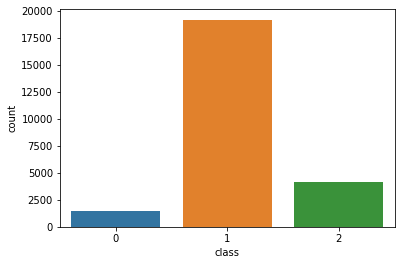

In [6]:
import seaborn as sns
sns.countplot('class', data=pandas_df)


In [7]:
pandas_df['tweet_cleaned'] = pandas_df['tweet'].str.replace('@[A-Za-z0-9]+\s?', '', regex=True)
pandas_df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,tweet_cleaned
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,!!! RT : As a woman you shouldn't complain abo...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,!!!!! RT : boy dats cold...tyga dwn bad for cu...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,!!!!!!! RT Dawg!!!! RT : You ever fuck a bitch...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,!!!!!!!!! RT _G_Anderson: _based she look like...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,!!!!!!!!!!!!! RT : The shit you hear about me ...


## Load dataframe from Pandas

In [8]:
from datasets import Dataset

ds = Dataset.from_pandas(pandas_df)
ds

Dataset({
    features: ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither', 'class', 'tweet', 'tweet_cleaned'],
    num_rows: 24783
})

In [9]:

dataset = load_dataset('csv', data_files=DATA_PATH, split='train')

dataset

Using custom data configuration default-f1b446edcc2fbcfb
Reusing dataset csv (/home/paul/.cache/huggingface/datasets/csv/default-f1b446edcc2fbcfb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


Dataset({
    features: ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither', 'class', 'tweet'],
    num_rows: 24783
})

In [10]:
train_test_valid = ds.train_test_split()

test_valid = train_test_valid['test'].train_test_split()

train_test_valid_dataset = DatasetDict({
    'train': train_test_valid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']
    })


dataset = train_test_valid_dataset.remove_columns(['hate_speech', 'offensive_language', 'neither','Unnamed: 0', 'count'])
dataset


DatasetDict({
    train: Dataset({
        features: ['class', 'tweet', 'tweet_cleaned'],
        num_rows: 18587
    })
    test: Dataset({
        features: ['class', 'tweet', 'tweet_cleaned'],
        num_rows: 1549
    })
    valid: Dataset({
        features: ['class', 'tweet', 'tweet_cleaned'],
        num_rows: 4647
    })
})

## Tokenizer

In [11]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [13]:
text = "Just checking tokenization"

output = tokenizer(text)

output

{'input_ids': [101, 2066, 9444, 22559, 2734, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [14]:
tokens = tokenizer.convert_ids_to_tokens(output['input_ids'])
tokens

['[CLS]', 'Just', 'checking', 'token', '##ization', '[SEP]']

In [15]:
print(f"Tokenized text: {tokenizer.convert_tokens_to_string(tokens)}")

Tokenized text: [CLS] Just checking tokenization [SEP]


In [16]:
print(f"Vocab size is : {tokenizer.vocab_size}")

print(f"Model max length is : {tokenizer.model_max_length}")

print(f"Model input names are: {tokenizer.model_input_names}")

Vocab size is : 28996
Model max length is : 512
Model input names are: ['input_ids', 'token_type_ids', 'attention_mask']


In [20]:
ds

Dataset({
    features: ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither', 'class', 'tweet', 'tweet_cleaned'],
    num_rows: 24783
})

In [22]:
def tokenize_function(train_dataset):
    return tokenizer(train_dataset['tweet_cleaned'], padding='max_length', truncation=True) 


tokenized_dataset = dataset.map(tokenize_function, batched=True)

tokenized_dataset

train_dataset = tokenized_dataset['train']
eval_dataset = tokenized_dataset['valid']
test_dataset = tokenized_dataset['test']

100%|██████████| 5/5 [00:00<00:00,  5.65ba/s]


In [23]:
train_dataset

Dataset({
    features: ['class', 'tweet', 'tweet_cleaned', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 18587
})

In [24]:
train_set = train_dataset.remove_columns(['tweet', "tweet_cleaned"]).with_format('tensorflow')

tf_eval_dataset = eval_dataset.remove_columns(['tweet', "tweet_cleaned"]).with_format('tensorflow')

tf_test_dataset = test_dataset.remove_columns(['tweet', "tweet_cleaned"]).with_format('tensorflow')

In [ ]:
train_features = { x: train_set[x] for x in tokenizer.model_input_names  }

train_set_for_final_model = tf.data.Dataset.from_tensor_slices((train_features, train_set['class'] ))

train_set_for_final_model = train_set_for_final_model.shuffle(len(train_set)).batch(8)


eval_features = {x: tf_eval_dataset[x] for x in tokenizer.model_input_names}
val_set_for_final_model = tf.data.Dataset.from_tensor_slices((eval_features, tf_eval_dataset["class"]))
val_set_for_final_model = val_set_for_final_model.batch(8)

test_features = {x: tf_test_dataset[x] for x in tokenizer.model_input_names}
test_set_for_final_model = tf.data.Dataset.from_tensor_slices((test_features, tf_test_dataset["class"]))
test_set_for_final_model =test_set_for_final_model.batch(8)

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)
# model = TFAutoModelForSequenceClassification.from_pretrained("/mnt/e0ccdbdb-22c3-4d9b-9413-fd976a2e99ae/M1/Code_Org/HF_Models/bert-base-uncased", num_labels=3)


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)


In [ ]:
history = model.fit(train_set_for_final_model, validation_data=val_set_for_final_model, epochs=3 )

In [ ]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model sparse categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_set_for_final_model,verbose=2)
print('\nTest accuracy:', test_acc)

In [ ]:
predict_score_and_class_dict = 
{0: 'Hate Speech',
 1: 'Offensive Language',
 2: 'Neither'}

preds = model(tokenizer(["He is useless, I dont know why he came to our neighbourhood", "That guy sucks", "He is such a retard"],return_tensors="tf",padding=True,truncation=True))['logits']

print(preds)

class_preds = np.argmax(preds, axis=1)

for pred in class_preds:
  print(predict_score_and_class_dict[pred])

In [ ]:
predict_score_and_class_dict = {0: 'Hate Speech',
 1: 'Offensive Language',
 2: 'Neither'}
preds = model(tokenizer(["He dresses up like a begger thise days"],return_tensors="tf",padding=True,truncation=True))['logits']
print(preds)
class_preds = np.argmax(preds, axis=1)

for pred in class_preds:
  print(predict_score_and_class_dict[pred])